In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Explore

In [19]:
with open('data/train.json') as data:
  dishes = pd.read_json(data)

In [3]:
print("There are {0} total recipes.".format(len(dishes['id'].unique())))
dishes.head()

There are 39774 total recipes.


,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [4]:
print("There are {0} total cuisines available.".format(len(dishes['cuisine'].unique())))
dishes['cuisine'].value_counts()

There are 20 total cuisines available.


italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

In [114]:
# Explode function in pandas 0.25
dishes = dishes.explode('ingredients')

print("There are {0} total unique ingredients.".format(len(dishes['ingredients'].unique())))
dishes.head()

There are 6714 total unique ingredients.


,id,cuisine,ingredients
0,10259,greek,romaine lettuce
0,10259,greek,black olives
0,10259,greek,grape tomatoes
0,10259,greek,garlic
0,10259,greek,pepper


In [6]:
def hbar_top_facet_grid(df, label, value, group, color='b'):
    # Get only top 5
    data = df.sort_values([group, value], ascending=False).groupby(group).head(5)

    # To view all styles: plt.style.available
    sns.set(style="white", font_scale = 1.9)

    # https://cduvallet.github.io/posts/2018/11/facetgrid-ylabel-access
    g = sns.FacetGrid(data.sort_values([group, value]), col=group, col_wrap=4, sharey=False, sharex=False, 
                      height=4, aspect=1.5)

    g = g.map(plt.barh, label, value, color=color)
    g = g.set_titles(col_template="{col_name}", size=24)
    g = g.set_xlabels(' ')
    g = g.set_ylabels(' ')

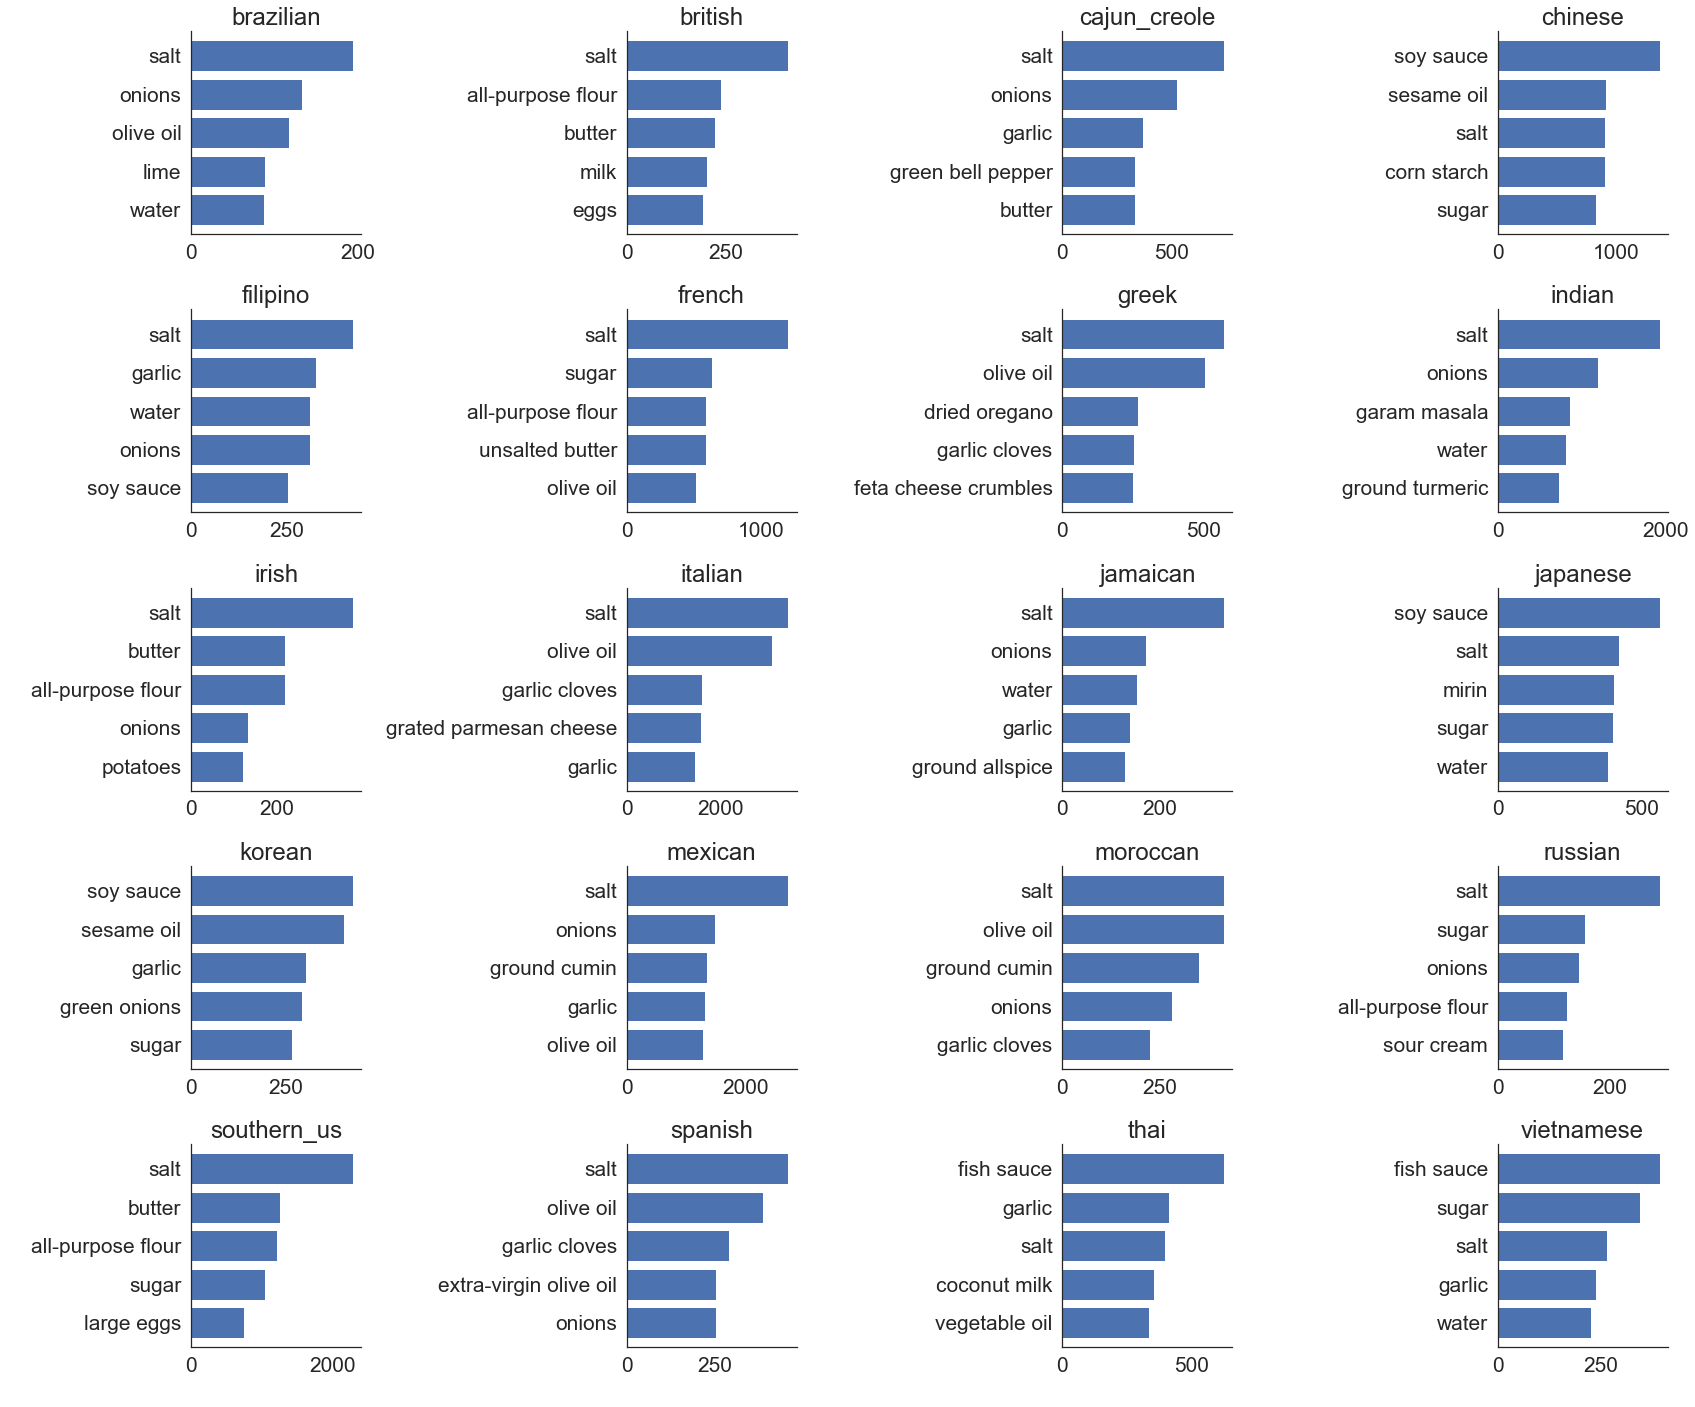

In [7]:
# group by ingredient - cuisine
data = pd.DataFrame(dishes.groupby(['cuisine', 'ingredients']).size().reset_index(name='count'))

hbar_top_facet_grid(data, 'ingredients', 'count', 'cuisine')

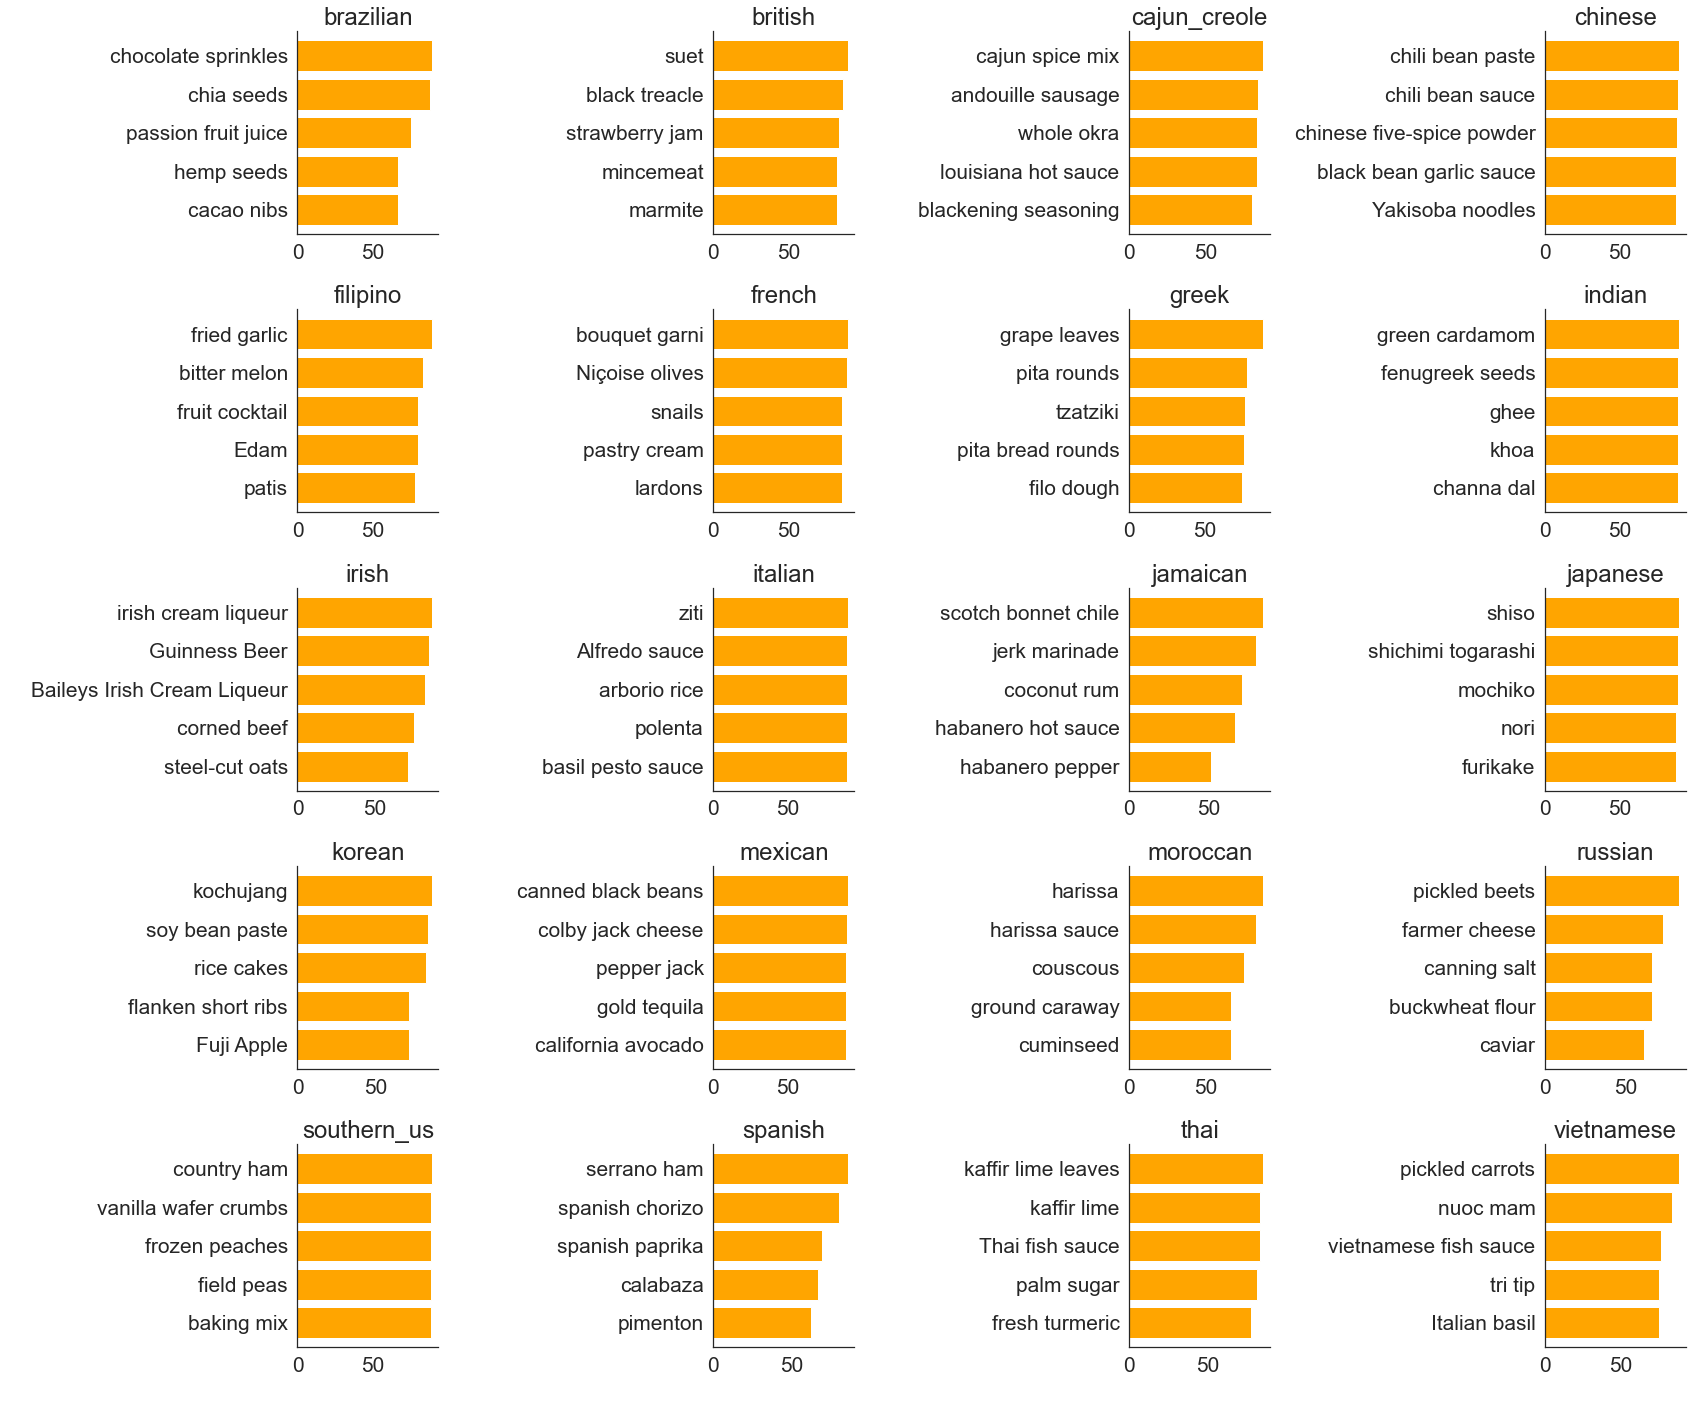

In [10]:
# How frequent is a specific cuisine ingredient used among all cuisines?
# we take advantage of groupby index from 
# https://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby
data = pd.DataFrame(dishes.groupby(['ingredients', 'cuisine']).size() / 
                    dishes.groupby('ingredients').size()).reset_index()
data.columns = ['ingredients', 'cuisine', 'relative_usage']
data['relative_usage'] = data['relative_usage']*100

# Still not quite right, some ingredients are only used once or twice, so they have x/x = 1 -> close to 100% usage
# to know the bins: data['relative_usage'].value_counts(bins=10)
# two options: 
# 1) keep ingredients appear in at least 10% of all recipes
# frequent = pd.DataFrame(dishes['ingredients'].value_counts(normalize=True).reset_index(name='density'))
# frequent_list = frequent[frequent['density'] >= .00001]['index'].tolist()
# data = data[data['ingredients'].isin(frequent_list)]

# 2) exclude relative usage < 90% - the top rarest
data = data[data['relative_usage'] < 90]

# redraw
hbar_top_facet_grid(data, 'ingredients', 'relative_usage', 'cuisine', color='orange')

Much more interesting!

## Food Network

In [11]:
import json
import itertools
import networkx as nx

In [18]:
with open('data/train.json') as data:
  dishes_json = json.load(data)

In [13]:
def get_combinations(l):
    '''input list of items and output all pair edges'''
    g = []
    for i in itertools.combinations(l ,2): #get all combos
        g.append(i)
    return g

In [15]:
# Make dict for edges
new_dict = []

for dish in dishes_json:
    edges_list = get_combinations(dish['ingredients'])
    for edges in edges_list:
        new_dict.append({'id':dish['id'], 'cuisine':dish['cuisine'], 'source': edges[0], 'target': edges[1]})  

In [137]:
# Get edge df
edge_df = pd.DataFrame.from_dict(new_dict).groupby(['source', 'target', 'cuisine']).size().reset_index(name='count')
edge_df.sort_values(by='count', ascending=False)[:10].reset_index(drop=True)

# Get node df
node_df = dishes.groupby(['cuisine', 'ingredients']).size().reset_index(name='size')

In [138]:
# Too many nodes + edges
print("Nodes: {0}".format(node_df.shape[0]))
print("Edges: {0}".format(edge_df.shape[0]))

Nodes: 29179
Edges: 1045934


In [139]:
# Get ingredients appear in at least 0.5% of EACH cuisine 
data = (dishes.groupby(['cuisine', 'ingredients']).size() / 
            dishes.groupby(['cuisine']).size()).reset_index(name='pct') #get pct
top_ingr = data[data['pct'] > 0.01] #filter

top_ingr_dict = {}
for key, g in top_ingr.groupby('cuisine'):
    top_ingr_dict[key] = g['ingredients'].tolist()

In [140]:
node_dfs, edge_dfs = [], []

for key, g in node_df.groupby('cuisine'):
    node_dfs.append(node_df[node_df['ingredients'].isin(top_ingr_dict[key])])

for key, g in edge_df.groupby('cuisine'):
    edge_dfs.append(edge_df[edge_df['source'].isin(top_ingr_dict[key]) & edge_df['target'].isin(top_ingr_dict[key])])
  
# Concat
node_df = pd.concat(node_dfs)
edge_df = pd.concat(edge_dfs)

In [141]:
# print
print("Nodes: {0}".format(node_df.shape[0]))
print("Edges: {0}".format(edge_df.shape[0]))

Nodes: 6489
Edges: 72376


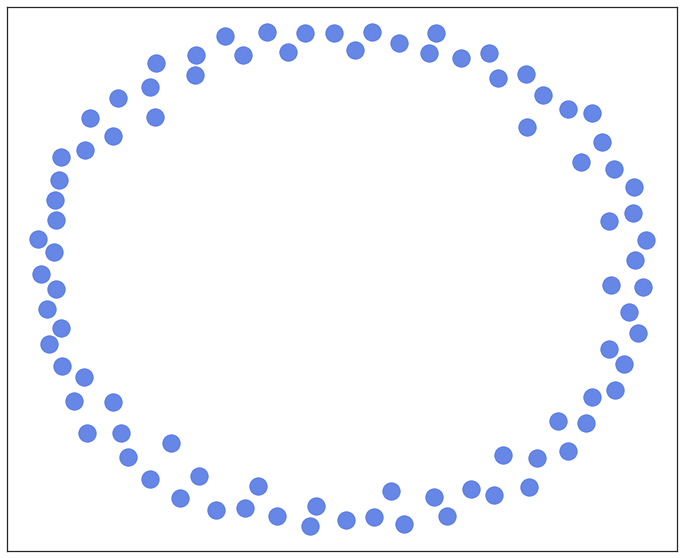

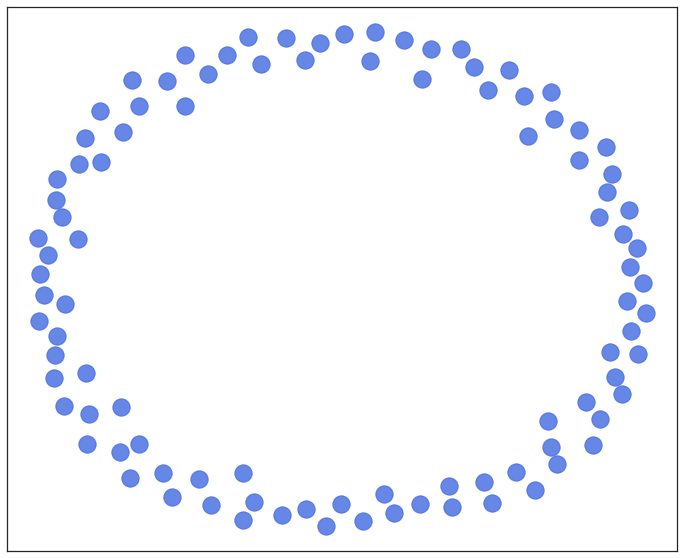

In [151]:
plt.rcParams['figure.figsize'] = (12, 10) #set figsize for all

for i in ['vietnamese', 'chinese']:
    n = node_df[node_df['cuisine'] == i]
    e = edge_df[edge_df['cuisine'] == i]
    
    G = nx.Graph()
    for node in n['ingredients'].unique():
        G.add_node(node)
        
    nx.draw_networkx_nodes(G=G, pos=nx.spring_layout(G), node_list=G.nodes(), node_color='royalblue',
                       alpha=0.8)
    nx.draw_networkx_edges(G=G, pos=nx.spring_layout(G), edge_color='red', alpha=0.2,
                       width=e['count'], arrows=False)
    plt.show()